# This notebook uses the train and test datasets with filled in missing timestamps.
Note: Adding missing timestamps didnot boost performance. There was a small increase in error, in the process.

In [10]:
%config Completer.use_jedi = False

In [11]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [40]:
# read in data

# sample submission
sample = pd.read_csv('../data/input/sample_4E0BhPN.csv', parse_dates=['date'])

# train with missing timestamps
train = pd.read_csv('../data/input/train_with_missing_timestamps.csv', parse_dates = ['date'])

# test with the demand of last year * 1.02 as demand
test = pd.read_csv('../data/input/test_with_missing_timestamps.csv', parse_dates=['date'])


In [13]:
# concatenate train and test_with_demand
train_test_concat =pd.concat([train, test])


In [14]:
# set datetime as index

train_test_concat.set_index(pd.to_datetime(train_test_concat.date) +\
                            pd.to_timedelta(train_test_concat.hour, unit='h'), inplace=True)

In [15]:
# date min

train_test_concat.index.min()

Timestamp('2018-08-18 09:00:00')

In [16]:
# date max

train_test_concat.index.max()

Timestamp('2022-03-28 23:00:00')

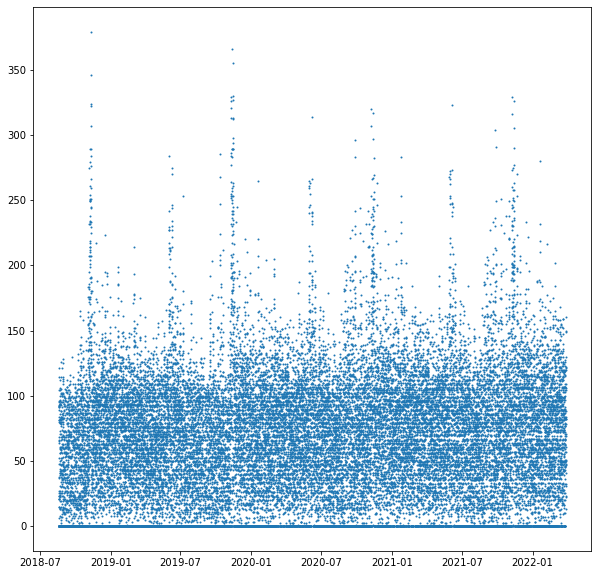

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(train_test_concat.index, train_test_concat.demand.values, s=1)
plt.show()

# Lag feature

In [18]:
# create lag features

def lag(df, lag_val=1):
    
    df[f'lag_{lag_val}'] = df['demand'].shift(lag_val)

In [19]:
# lag features

for i in [1,2,3,4,5,6,7, 30, 180, 365]:
    lag(train_test_concat, i)

In [20]:
# fill na with -99

train_test_concat.fillna(-99, inplace=True)

# Rolling mean

In [21]:
# calculate rolling mean

def rolling_mean(df, window ):
    
    mean =  df['demand'].rolling(
        window = window,       
        center=True
    ).mean()
    
    return mean
    

In [22]:
windows = ['1D', '7D', '30D', '365D']

for win in windows:
    
    train_test_concat.loc[:,win] = rolling_mean(train_test_concat, win) 

# Feature Engineering

In [23]:
# create time dummy

def time_dummy(df):
    
    df['time_dummy'] = np.arange(len(df.index))
    
    return df

In [24]:
# convert datetime to day, month, year

def convert_datetime_to_day_month_year(df):
    
    date_col = df.index
    
    df['day'] = date_col.day
    df['month'] = date_col.month
    df['year'] = date_col.year
    
    return df
    

In [25]:
# get day of week

def day_of_week(df):
    
    date_col = df.index
    
    df['day_of_week'] = date_col.weekday
    return df

In [26]:
# if weekend or weekday

def is_weekend(df):
    
    date_col = df.index
    
    df['is_weekend'] = np.where(df['day_of_week']<5, 0, 1)
    return df

In [27]:
# week of year

def week_of_year(df):
    
    date_col = df.index
    
    df['week_of_year'] = date_col.isocalendar().week.astype(int)
    
    return df

In [28]:
# Add holidays

def is_holiday(df):
    
    date_col = df.index
    
    Indian_holidays = holidays.India()
    df['is_holiday'] = date_col.isin(Indian_holidays).astype(int)
    return df



In [29]:
# whether it is day or night

def is_day(df):
    
    df['is_day'] = df.apply(lambda row: 1 if (row['hour']>=6 and row['hour']<=18) else 0, axis=1)
    
    return df
    

In [30]:
# Add new features

def add_features(df):
    
    date_col = df.index
    
    # create time dummy
    df = time_dummy(df)
    
    # add day, month, year
    df = convert_datetime_to_day_month_year(df)
    
    # day of week
    df = day_of_week(df)
    
    # is weekend
    df = is_weekend(df)
    
    # week of year
    df = week_of_year(df)
    
    # add holidays
    df = is_holiday(df)
    
    # is day
    df = is_day(df)
    
    return df

In [31]:
train_test_concat_features = add_features(train_test_concat)

# train - test split

In [32]:
train_new = train_test_concat_features.loc['2018-08-18':'2021-02-28']

In [33]:
test_new = train_test_concat_features.loc['2021-03-01':]

# Modelling

In [34]:
# prepare train and test

def prepare_df(train):
    
    # make X_train
    X_train = train.drop(columns=['date','demand']).copy()
    
    # make y_train
    y_train = train['demand'].copy().values
    
    return X_train, y_train

In [35]:
X_train, y_train = prepare_df(train_new)

In [36]:
X_test,_ = prepare_df(test_new)

In [37]:
def model_fit_predict(model, X_train, y_train, X_test):
    
    # fit model
    model.fit(X_train, y_train)
    
    # predict
    y_predict = model.predict(X_test)
    
    # add to test 
    X_test_copy = X_test.copy()
    X_test_copy.loc[:,'demand'] = y_predict.astype(int)
    
    return X_test_copy
    

## XGB

In [32]:
model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01,\
                         max_depth=8, colsample_bytree=0.7, subsample =0.7)

In [33]:
X_test_with_prediction_xgb = model_fit_predict(model_xgb, X_train, y_train, X_test)

## Linear Regression

In [34]:
model_linear = LinearRegression()

In [35]:
X_test_with_prediction_linear = model_fit_predict(model_linear, X_train, y_train, X_test)

## Random Forests

In [ ]:
# random forest

In [60]:
model_RF = RandomForestRegressor(n_estimators=500, max_depth=8, min_samples_split=10, min_samples_leaf=5)

In [61]:
X_test_with_prediction_RF = model_fit_predict(model_RF,X_train, y_train, X_test)

# submission

In [71]:
# set datetime as index

sample.set_index(pd.to_datetime(sample.date) +\
                            pd.to_timedelta(sample.hour, unit='h'), inplace=True)

In [72]:
# merge sample and prediction
# xgb
submission_xgb = sample[['date','hour']].merge(X_test_with_prediction_xgb[['demand']], \
                                               right_index=True, left_index=True, how='inner')

# linear 
submission_linear = sample[['date','hour']].merge(X_test_with_prediction_linear[['demand']], \
                                                  right_index=True, left_index=True, how='inner')

# RF
submission_RF = sample[['date','hour']].merge(X_test_with_prediction_RF[['demand']], \
                                                  right_index=True, left_index=True, how='inner')

In [73]:
# save to csv

submission_RF.to_csv('../data/output/s17.csv', index=None)

# Average of all models

In [47]:
ensemble_avg = (submission_xgb['demand'].values + submission_linear['demand'].values + submission_RF['demand'].values) /3.

In [55]:
# submission

sample.loc[:,'demand'] = ensemble_avg.astype(int)

In [57]:
# save to csv

sample.to_csv('../data/output/s17.csv', index=None)